# The LOTlib3 library

> __**NOTE**__ This is based on Piantadosi's introduction to LOTlib3, which you can find [here](https://github.com/piantado/LOTlib3/blob/master/Documentation/Tutorial.md).

In [2]:
try:
    # in colab
    import google.colab
    print('In colab, downloading LOTlib3')
    !git clone https://github.com/thelogicalgrammar/LOTlib3
except:
    # not in colab
    print('Not in colab!')

Not in colab!


## Setting up a domain & an inference problem

LOTlib3 is an inference library. Specifically, it infers compositions of functions from observations of inputs-outputs or just outputs (if there is no input). Today we will consider a simple inference problem and how to solve it using LOTlib3. 

### A simple domain

Suppose that you know some basic arithmetic operations, our _primitives_ in this domain: 
- addition (+)
- subtraction (-)
- multiplication (*)
- division (/)

We can use these primitives to define a simple CFG:
$$
S \to (S + S) \mid (S - S) \mid (S * S) \mid (S / S) \mid 1 \mid ... \mid 10 
$$

Each production of this CFG can be interpreted into a (rationa) number. The interpretation of this CFG is given by usual arithmetic. Note that it is possible to encode any number with an infinite variety of possible expressions in this CFG. For instance, 12 may be written as $(1+1) * 6$, or it may have been written as $1 + 11$, or $2 * 3 * 2$, etc.:

\begin{align}
(1+1) * 6 &= 12 \\
12+(1-1+1-1+1-1+1-1+1-1+1-1+1-1+1-1) &= 12
\end{align}

In order to transform this CFG into a PCFG, we need to assign a probability to each production rule. A natural way of doing it is as follows (with unnormalized probabilities):
\begin{align}
(S + S) & \to 1.0 &\text{Operators get the same probability} \\
(S - S) & \to 1.0 \\
(S * S) & \to 1.0 \\
(S / S) & \to 1.0 \\
1 & \to 10*\frac{1}{1^2} &\text{Numerals get different probabilities} \\
&... \\
10 & \to 10*\frac{1}{10^2} 
\end{align}
We use probability $\frac{1}{n^2}$ for numeral $n$ so that numerals referring to smaller numbers get a higher prior probability of appearing in a formula, but we also multiply all probabilities by 10 to increase the total probability of producing a numeral over the other productions.

Here is a possible production from this grammar:

\begin{align}
S
&\to (S+S) \\
&\to ((S/S)+S) \\
&\to ((1/S)+S) \\
&\to ((1/(S-S))+S) \\
&\to ((1/(2-S))+S) \\
&\to ((1/(2-1))+S) \\
&\to ((1/(2-1))+(S-S)) \\
&\to ((1/(2-1))+(4-S)) \\
&\to ((1/(2-1))+(4-2)) \\
\end{align}

And this expression evaluates to the number 3!

This should all be familiar from previous classes. However, now we add something new, which is at the very core of the LoT project. Suppose you have the following problem: You observe a number, and you want to infer which formula in the PCFG above generated it. To address this problem, we will need to combine all the topics we have covered so far. The general plan is:
1. We define a PCFG, which gives us a prior probability $P(s)$ over productions $s$ from the CFG.
2. We define a likelihood function $P(o \mid s)$, which gives us the probability of an observation (or set of observations) $o$ given a production $s$ from the PCFG.
3. Given some data $o$, we run approximated Bayesian inference to find a posterior distribution $P(s \mid o)$.

For instance, suppose you observe the single number 12. There are lots of ways (infinitely many) to generate 12.  Which one is correct?  Ay composition of addition, subtraction, multiplication, etc. that outputs a 12 would be _consistent_ with the data. However, some seem more plausible than others. For instance it might be unlikely the 12 was generated as $12+(1-1+1-1+1-1+1-1)$ as it seems an unnecessarily complex way to arrive at 12.  LOTLib3 is designed to help you make sensible decisions about which compositions of functions likely explain a particular set of outputs or input-output pairs.

### Defining a domain grammar

The general strategy of LOTlib3 models is to start by specifying a probabilistic context-free grammar (with one small exception described below) that specifies a prior distribution on trees, or equivalently compositional structures like $(1+1)*6$, $2+2+2+2+2+2$, $(1+1)+(2*5)$, etc. We set the grammar up so that each production from it will be a valid Python expression, which can be interpreted automatically rather than manually.

Let's see how to construct a simple example grammar step-by-step. First, we import the Grammar class:

In [ ]:
from LOTlib3.Grammar import Grammar

Second, we define a grammar object (By default this has a start symbol called 'START' but we want to call it 'EXPR'):

In [24]:
grammar = Grammar(start='EXPR')

The `grammar` object will contain the information about our PCFG.

Third, we add the substitution rules to the grammar, along with the (unnormalized) probabilities of each rule:

In [25]:
# Define some operations
grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(float(%s) / float(%s))', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(-%s)', ['EXPR'], 1.0)

# And define some numbers. We'll give them a 1/(n^2) probability
for n in range(1,10):
    grammar.add_rule('EXPR', str(n), None, 10.0/(n**2))

The grammar rules have the format:
```python
grammar.add_rule( <NONTERMINAL>, <FUNCTION>, <ARGUMENTS>, <PROBABILITY>)
```
where:
- `<NONTERMINAL>` says what nonterminal this rule is expanding (the left side of a substitution rule). In this example, there is only one kind of nonterminal, an expression (denoted `EXPR`).
- `<FUNCTION>` does two things at once: first, it defines the right side of the substitution rule, and second it specifies the its interpretation (the Python function that this rule represents). `<FUNCTION>` is a string which contain either predefined functions in LOTlib3 or some other valid Python code. In the latter case (as in the example above), the string can contain a `%s` wherever there is a nonterminal in the substitution.
- `<ARGUMENTS>` specifies which nonterminal(s) appear in the right-hand side of the substitution described in `<FUNCTION>`. `<ARGUMENTS>` is a list containing one element for each `%s` in `<FUNCTION>`. Each `%s` in `<FUNCTION>` gets substituted via string substitution with the corresponding nonterminal in `<ARGUMENTS>`. For instance,  if `<FUNCTION>` is `(%s+%s)` and `<ARGUMENTS>` is `['EXPR', 'EXPR']`, the whole right side of the replacement rule is `EXPR + EXPR`, and it is interpreted as the function `lambda x,y: x+y`. Note that the `<FUNCTION>` string can be pretty complex. For division, we have `(float(%s) / float(%s))`, using some Python operations.
- NOTE: A generation from the grammar is interpreted with `eval`, which is why we can use Python expressions.
- A terminal is any rule with `None` or an empty list as `<ARGUMENTS>`.

If the `<FUNCTION>` is a terminal that does not take arguments (as in the numbers 0..9), the `<ARGUMENTS>` part of a rule should be None. None is very different from an empty list, since an empty list corresponds to a function with zero arguments, while None to a constant expression (not a function):
```
grammar.add_rule('EXPR', 'hello', None, 1.0)
```
renders into the program `hello` but 
```
grammar.add_rule('EXPR', 'hello', [], 1.0)
```
renders into `hello()`.
    
We can see some productions from this grammar if we call `Grammar.generate`. We will also show the probability of this tree according to the grammar, which is computed by renormalizing the `<PROBABILITY>` values of each rule when expanding each nonterminal:

In [19]:
for _ in range(10):
    t = grammar.generate()
    print(grammar.log_probability(t), t)

-3.8814440645728694 5
-0.6625682397046684 1
-2.048862600824559 2
-19.92698669181795 (3 * (-(float(1) / float((5 + 1)))))
-0.6625682397046684 1
-3.43515696194445 4
-2.048862600824559 2
-3.6277215724033827 (-1)
-0.6625682397046684 1
-0.6625682397046684 1


As you can see, the longer/bigger trees have lower (more negative) probabilities, implementing essentially a simplicity bias. These PCFG probabilities will often be our prior for Bayesian inference. 

Note that even though each `t` is a tree (a hierarchy of `LOTlib3.FunctionNodes`), it renders nicely above as a string. This is how expressions are evaluated in Python by default. But we can see more of the internal structure using `t.fullprint()`, which shows the nonterminals, functions, and arguments at each level:
    

In [13]:
t = grammar.generate()
t.fullprint()

 EXPR (%s * %s) 	 None
  .   EXPR (-%s) 	 None
  .    .   EXPR 1 	 None
  .   EXPR (%s * %s) 	 None
  .    .   EXPR 1 	 None
  .    .   EXPR 1 	 None


There is a column in this output that should say 'None' for each row of the output.  It is ok to ignore that for now.

### Defining a hypothesis

We have seen above how to specify a grammar, encoding a space of expressions and their interpretation. However, before we can run inference with some observation, we need some way of encoding functions for computing the prior and the likelihood of data, as well as other information we might need about the thing we want to infer. All this information could be stored in various way, but in LOTlib3 we encode it by defining a class (which we call the `Hypothesis` class) that inherits from a predefined `LOTHypothesis` class (there are other Hypothesis classes to inherit from but do not worry about that for now). We will call `hypotheses' the specific objects defined from this class.

> __NOTE__ An hypothesis in LOTlib3 is not a _specific_ hypothesis produced by the PCFG, but rather just a way of encoding the stuff we need to run inference, including a likelihood function and a prior function. Essentially, we need it to pass information about the inference problem to the inference function.

Let's look how this is done by defining a Hypothesis class `MyHypothesis` for the PCFG above:

In [112]:
from math import log, exp
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis

# define a hypothesis
class MyHypothesis(LOTHypothesis):
    
    def __init__(self, **kwargs):
        # initialize by running the superclass' init
        # with the appropriate arguments.
        LOTHypothesis.__init__(
            self, 
            grammar=grammar, 
            display="lambda: %s", 
            **kwargs
        )

    def compute_single_likelihood(self, datum):
        """Define the loglikelihood function P(datum | self)"""
        # probability of a random number btw 1 and 100
        # being observed by noise rather than the true number
        prob_of_random_number = (1.0-datum.alpha)/100.
        # If the hypothesis called with the datum's input
        # is equal to the output...
        if self(*datum.input) == datum.output:
            # return the logprobability!
            return log(prob_of_random_number + datum.alpha)
        else:
            return log(prob_of_random_number) 

There are a few things going on here. First, we import LOTHypothesis and use that to define the new class `MyHypothesis`. The `self` attribute of `MyHypothesis` can be called like a function, and in a specific instantiation of `MyHypothesis` that function will be the interpreted hypothesis (more on this below).

Then, we define the initializer `__init__`, which calls the `__init__` of the superclass `LOTHypothesis`. The `LOTHypothesis` init takes various arguments. First, a `grammar` argument to specify a Grammar object; in our case, we specify that the grammar we want is the one defined above, `grammar`. Then, the `display` argument, which allows us to specify how we want the Hypotheses to be displayed. When we convert the value of the hypothesis into a string, it will get substituted into the `display` keyword. Here, `display="lambda: %s"` means that the hypothesis will be displayed and also evaled in python as appearing after a `lambda` without any arguments.

The second thing we have done when defining `MyHypothesis` is defining a method `compute_single_likelihood`. What does this function do, conceptually? It takes a single observation and returns the logarithm of the likelihood given the (currently considered) hypothesis: $P(\mathrm{observation} \mid \mathrm{hypothesis})$. We get to decide what the value of this probability is. Note that in general each production from our PCFG can encode a function. In that case the observations are (input, output) tuples, where the output is obtained by running the input through the (unknown) interpreted PCFG production. Therefore, in general we need the following components to write the likelihood function:
- An observation, containing an input, an output, and whatever other parameters we need to calculate the likelihood.
- A way of calling the input on the currently entertained hypothesis.

Practically, `compute_single_likelihood` expects an argument `datum`; `datum` must have attributes `input`, `output`, and whatever other parameters we need for the calculation of the likelihood (in this case, `alpha`). The LOTHypothesis `self` can be viewed as the function encoding the currently considered hypothesis (here, one with no arguments) and so it can be called on `datum.input`. When we construct a hypothesis object, a random production is drawn from the PCFG; when we use the hypothesis object as part of the inference, the initial hypothesis stored in the object is updated with a new production on every step of the MCMC run, and `self` (which is the interpretation of the production as a callable python function) changes accordingly; more on this below when we look at how hypothesis objects are used for inference. 

In the specific likelihood function defined above, we generate a random number from 1 to 100 with probability `1-datum.alpha` and the correct number with probability `datum.alpha`. Thus, when the hypothesis returns the correct value (e.g. `self(*datum.input) == datum.output`) we must add these quantities to get the total probability of producing the data. When it does not, we must return only the former. `LOTlib3.Hypotheses.Likelihoods` defines a number of other standard likelihoods, including the most commonly used  one, `BinaryLikelihood`. 

LOTHypothesis defines `compute_prior()` and `compute_likelihood(data)`. Essentially, `compute_likelihood` maps `compute_single_likelihood` over a list of data (treating each as independent identically-distributed conditioned on the hypothesis). So when we want to define how the likelihood works, we typically want to overwrite `compute_single_likelihood` as we have above.

### Adding 0s to the grammar

As you might have noticed we did not allow the number 0 as a terminal value in our grammar.  This is because it ran the risk of a divide by zero error.  However, we might like to include all the numbers between zero and nine.  So let's change that one part of our grammar definiton by replacing the lines where the number substitution rules are defined. First, define a clean grammar and add the operators:

In [27]:
grammar = Grammar(start='EXPR')

# Define the same operations as above
grammar.add_rule('EXPR', '(%s + %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(%s * %s)', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(float(%s) / float(%s))', ['EXPR', 'EXPR'], 1.0)
grammar.add_rule('EXPR', '(-%s)', ['EXPR'], 1.0)

EXPR -> (-%s)['EXPR']	w/ p=1.0

Then, add the number replacement rules including 0 with the new probabilities:

In [28]:
# Define some numbers. 
# We'll give them a 1/((n+1)^2) probability
# so that 0 naturally gets a probability.
for n in range(10):
    grammar.add_rule('EXPR', str(n), None, 10.0/((n+1)**2))

Now we have a problem, namely, it can happen that the grammar generates an expression like `1/0`, with a zero in the demoninator. This will generate a divide by zero error when evaluated by the Python interpreter. How do we deal with this? Fortunately, we can hack our hypothesis class to address this by catching the exception. A smart way to do this is to override `__call__` and return an appropriate value when such an error occurs:

In [ ]:
class MyHypothesis(LOTHypothesis):
    
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(self, grammar=grammar, display="lambda: %s", **kwargs)
        
    def __call__(self, *args):
        try:
            # try to do it from the superclass
            return LOTHypothesis.__call__(self, *args)
        except ZeroDivisionError:
            # and if we get an error, return nan
            return float("nan")

    def compute_single_likelihood(self, datum):
        if self(*datum.input) == datum.output:
            return log((1.0-datum.alpha)/100. + datum.alpha)
        else:
            return log((1.0-datum.alpha)/100.)

### Defining a data storage

Given that our hypothesis wants those kinds of data, we can then create data as follows:

In [95]:
from LOTlib3.DataAndObjects import FunctionData
data = [ 
    # a single datum
    FunctionData(
        # input is empty since we are 
        # encoding a single number
        input=[], 
        # the observation we want to encode
        output=12, 
        # the probability of 
        # observing the true number
        alpha=0.999
    ) 
]

Note here that the most natural form of data is a list--even if it is only a single element--where each element, a datum, gets passed to `compute_single_likelihood`. The data here specifies the input, output, and noise value `alpha`. Note that even though `alpha` could live as an attribute of hypotheses, it makes most sense to view it as a known part of the data. Here input is a empty list because there is no input!  Remember the example we started with was explaining a single output (the number 12).  Keep reading to understand examples with an input below!

### Putting data in a hypothesis

We may now use our definition of a hypothesis to make one. If we call the initializer without a `value` keyword, LOTHypothesis just samples it from the given grammar: 

In [75]:
h = MyHypothesis()
print(h.compute_prior(), h.compute_likelihood(data), h)

-14.800602876662946 -9.210340371976182 lambda: (0 + (4 + (0 + 0)))


Even better, `MyHypothesis` also inherits a `compute_posterior` function:

In [76]:
print(h.compute_posterior(data), h.compute_prior(), h.compute_likelihood(data), h)

-24.01094324863913 -14.800602876662946 -9.210340371976182 lambda: (0 + (4 + (0 + 0)))


For convenience, when `compute_posterior` is called, it sets attributes on `h` for the prior, likelihood, and unnormalized posterior (i.e., log(prior times likelihood)):

In [77]:
h = MyHypothesis()
h.compute_posterior(data)
print(h.posterior_score, h.prior, h.likelihood, h)

-9.878050625235126 -0.6677102532589441 -9.210340371976182 lambda: 0


## Running the inference

We are almost there. We have done the following:
- Defined a grammar object that encodes our PCFG
- Defined a hypothesis object which uses the grammar to calculate a prior and also includes a function to calculate a likelihood. 
- Defined a list containing data objects, which encode the observed data as well as parameters needed to calculate the likelihood.

Now we can see the main point of LOTlib3: we can simply import MCMC routines and do inference over the space defined by the grammar. To do this, we first import the Metropolis Hastings sampler:

In [ ]:
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler

Then, we define a starting hypothesis, which internally samples an initial random guess from the PCFG:

In [ ]:
# define a "starting hypothesis". This one is essentially copied by 
# all proposers, so the sampler doesn't need to know its type or anything. 
h0 = MyHypothesis()

Finally, we use the sampler like an iterator. MetropolisHastingsSampler takes the hypothesis object, the observed data, and the number of posterior samples we want to take, and produces the samples using the MCMC algorithm. MetropolisHastingsSampler calls the hypothesis' `compute_posterior` so when we have an `h` we can get its prior and likelihood:

In [111]:
for h in MetropolisHastingsSampler(h0, data, steps=10):
    print(h.posterior_score, h.prior, h.likelihood, h)
    print('Prior:                    ', exp(h.prior))
    print('Likelihood:               ', exp(h.likelihood))
    print('(Unnormalized) posterior: ', exp(h.posterior_score))
    print('Hypothesis:               ', h)
    print('Interpretation:           ', h())
    print()

-13.566930079349062 -2.054004614378835 -11.512925464970227 lambda: 1
Prior:                     0.12822040082201266
Likelihood:                1.0000000000000016e-05
(Unnormalized) posterior:  1.2822040082201285e-06
Hypothesis:                lambda: 1
Interpretation:            1

-12.180635718229171 -0.6677102532589441 -11.512925464970227 lambda: 0
Prior:                     0.5128816032880508
Likelihood:                1.0000000000000016e-05
(Unnormalized) posterior:  5.128816032880515e-06
Hypothesis:                lambda: 0
Interpretation:            0

-12.180635718229171 -0.6677102532589441 -11.512925464970227 lambda: 0
Prior:                     0.5128816032880508
Likelihood:                1.0000000000000016e-05
(Unnormalized) posterior:  5.128816032880515e-06
Hypothesis:                lambda: 0
Interpretation:            0

-13.566930079349062 -2.054004614378835 -11.512925464970227 lambda: 1
Prior:                     0.12822040082201266
Likelihood:                1.00000000

Just looking at a list of individual samples is not a very practical way of analysing the results of an MCMC run. A cleaner way of storing the posterior samples is to accumulate them in a Counter, using the hypotheses as keys and the counts as values. Let's first get the samples and put them in the counter:

In [99]:
from collections import Counter

h0 = MyHypothesis()

count = Counter()
for h in MetropolisHastingsSampler(h0, data, steps=100000):
    count[h] += 1

And now we can print them out, in order of increasing posterior probability. If the above worked correctly, many of the most likely hypotheses should evaluate to the number 12:

In [104]:
for h in sorted(count.keys(), key=lambda x: count[x])[-10:]:
    print('Count:          ', count[h])
    print('Posterior:      ', exp(h.posterior_score))
    print('Hypothesis:     ', h)
    print('Interpretation: ', h())
    print()

Count:           886
Posterior:       8.863300048096163e-07
Hypothesis:      lambda: ((4 + 0) * 3)
Interpretation:  12

Count:           1140
Posterior:       2.2158250120240445e-07
Hypothesis:      lambda: (3 + (9 + 0))
Interpretation:  12

Count:           1189
Posterior:       6.655737304579818e-06
Hypothesis:      lambda: (4 + 8)
Interpretation:  12

Count:           1299
Posterior:       8.863300048096163e-07
Hypothesis:      lambda: ((0 + 4) * 3)
Interpretation:  12

Count:           1547
Posterior:       1.2822040082201285e-06
Hypothesis:      lambda: 1
Interpretation:  1

Count:           6172
Posterior:       5.128816032880515e-06
Hypothesis:      lambda: 0
Interpretation:  0

Count:           7500
Posterior:       3.36946701044353e-05
Hypothesis:      lambda: (3 * 4)
Interpretation:  12

Count:           13781
Posterior:       3.056205905164204e-05
Hypothesis:      lambda: (6 * 2)
Interpretation:  12

Count:           19710
Posterior:       8.423667526108823e-06
Hypothesis:  

LOTlib3 hypotheses are required to hash nicely, meaning that they can be saved or put into dictionaries and sets like this. 

If our sampler is working correctly, it should be the case that the time average of the sampler (the hypotheses from the `for` loop) should approximate the posterior distribution (e.g. their re-normalized scores). Let's check if that's true:

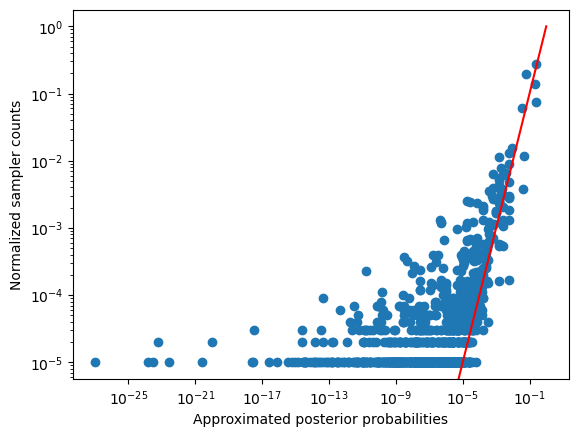

In [110]:
# Miscellaneous stores a number of useful functions. Here, we need logsumexp, which will
# compute the normalizing constant for posterior_scores when they are in log space
from LOTlib3.Miscellaneous import logsumexp
# but things that are handy in numpy are not duplicated (usually)
from numpy import exp 

# get a list of all the hypotheses we found. 
# This is necessary because we need a fixed order,
# which count.keys() does not guarantee 
# unless we make a new variable. 
hypotheses = count.keys() 

# first convert posterior_scores to probabilities. To this, we'll use a simple hack of 
# renormalizing the posterior_scores that we found. This is a better estimator of each hypothesis'
# probability than the counts from the sampler
z = logsumexp([
    h.posterior_score 
    for h in hypotheses
])

posterior_probabilities = [ 
    exp(h.posterior_score - z) 
    for h in hypotheses 
]

# and compute the probabilities over the sampler run
cntz = sum(count.values())    
sampler_counts = [ 
    float(count[h])/cntz 
    for h in hypotheses 
] 

## and let's just make a simple plot
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()
ax.scatter(posterior_probabilities, sampler_counts)
ax.plot(
    [0,1], 
    [0,1], 
    color='red'
)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Approximated posterior probabilities')
ax.set_ylabel('Normalized sampler counts')

fig.show()

## Things to try out

- What happens if we make the $\alpha$ higher or lower?
- What happens to the inferred hypotheses if we add another datapoint with a different number?
- What happens if we decrease the prior weight of the numerals?